In [4]:
import json
import lzma
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import re
from tqdm import tqdm
from IPython.core.display import display, HTML
import re
from nltk.tokenize import RegexpTokenizer

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords   
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings("ignore")

from attention import AttentionLayer
# tokenizer = RegexpTokenizer('\s+', gaps=True)

In [5]:
# pre-processing functions
def text_cleaner(text):
    text_clean = text.splitlines()
    text_clean = " ".join(text_clean)
    return text_clean

In [6]:
# experimenting
text = 'my text \n yes.!$'
text_cleaner(text)

'my text   yes.!$'

In [7]:
def get_cases(state, subset=True, num_cases=100):
    cases = []
    with lzma.open(state + '/data/data.jsonl.xz', 'r') as jsonl_file:
        for i, case in enumerate(jsonl_file):
            c = json.loads(str(case, 'utf-8'))

            date = c['decision_date']
            
            headnotes = c['casebody']['data']['head_matter']
            if headnotes == []:
                continue
            headnotes = text_cleaner(headnotes)
            num_head = len(headnotes)
            
            name = text_cleaner(c['name'])
            docket_number = text_cleaner(c['docket_number'])

            opinions = c['casebody']['data']['opinions']
            if opinions == []:
                continue

            opinions = text_cleaner(opinions[0]['text'])
            body = name + docket_number + opinions
            num_body = len(body)
                
            cases.append({'date':date, 'num_head':num_head, 'head':headnotes, 'num_body':num_body, 'body':body})
            if subset == True:
                if i > num_cases:
                    break
        return pd.DataFrame(cases)

In [8]:
df = get_cases('North Carolina', subset=False, num_cases=10)
df['head'] = df['head'].apply(lambda x: '_START_ '+ x + ' _END_')
df.shape

(97586, 5)

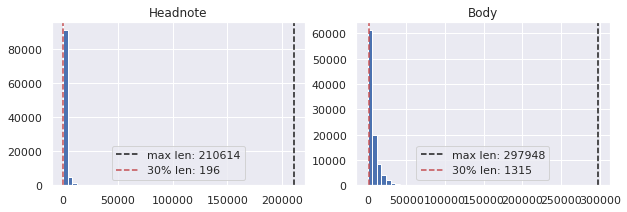

In [9]:
q = 30
q_head = int(np.percentile(df.num_head,q))
q_body = int(np.percentile(df.num_body,q))

f, ax = plt.subplots(1,2,figsize=[10,3])
ax[0].hist(df.num_head, bins=50)
ax[0].axvline(np.max(df.num_head), label='max len: ' + str(np.max(df.num_head)), color='k', ls='--')
ax[0].axvline(q_head, label=str(q) + '% len: ' + str(q_head), color='r', ls='--')
ax[0].set_title('Headnote')
ax[0].legend()
ax[1].hist(df.num_body, bins=50)
ax[1].axvline(np.max(df.num_body), label='max len: ' + str(np.max(df.num_body)), color='k', ls='--')
ax[1].axvline(q_body, label=str(q) + '% len: ' + str(q_body), color='r', ls='--')
ax[1].legend()
ax[1].set_title('Body')
plt.show()

In [10]:
# limiting the dataset
max_head = q_head
max_body = q_body

df = df[(df['num_head'] <= q_head) & (df['num_head'] > 4) & 
        (df['num_body'] <= q_body) & (df['num_body'] > 4)]
print(df.shape)
display(df[['num_head']].describe().T)
display(df[['num_body']].describe().T)

(22119, 5)


,count,mean,std,min,25%,50%,75%,max
num_head,22119.0,53.478096,43.994866,10.0,27.0,35.0,53.0,196.0


,count,mean,std,min,25%,50%,75%,max
num_body,22119.0,221.502374,221.412946,20.0,114.0,137.0,229.0,1315.0


41
253


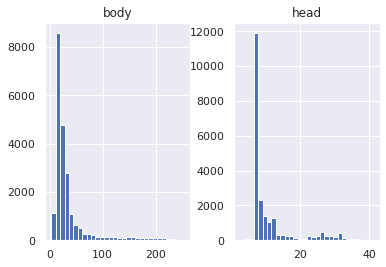

In [11]:
text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in df['body']:
      text_word_count.append(len(i.split()))

for i in df['head']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'body':text_word_count, 'head':summary_word_count})
max_head = length_df['head'].max()
max_body = length_df['body'].max()
print(max_head)
print(max_body)
length_df.hist(bins = 30)
plt.show()

In [29]:
x_tr, x_val, y_tr, y_val = train_test_split(df['body'], df['head'], test_size=0.2, random_state=42)

In [30]:
# tokenize sequences
x_toke = Tokenizer()
x_toke.fit_on_texts(list(x_tr))
x_tr = x_toke.texts_to_sequences(x_tr)
x_val = x_toke.texts_to_sequences(x_val)

# padding
x_tr = pad_sequences(x_tr, maxlen=max_body, padding='post')
x_val = pad_sequences(x_val, maxlen=max_body, padding='post')

x_voc_size   =  len(x_toke.word_index) + 1

In [31]:
# tokenize sequences
y_toke = Tokenizer()
y_toke.fit_on_texts(list(y_tr))
y_tr = y_toke.texts_to_sequences(y_tr)
y_val = y_toke.texts_to_sequences(y_val)

# padding
y_tr = pad_sequences(y_tr, maxlen=max_head, padding='post')
y_val = pad_sequences(y_val, maxlen=max_head, padding='post')

y_voc_size   =  len(y_toke.word_index) + 1

# Model

In [32]:
from keras import backend as K 
K.clear_session() 
latent_dim = 500 

# Encoder 
encoder_inputs = Input(shape=(max_body,)) 
enc_emb = Embedding(x_voc_size, latent_dim, trainable=True)(encoder_inputs) 

#LSTM 1 
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb) 

#LSTM 2 
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1) 

#LSTM 3 
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True) 
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2) 

# Set up the decoder. 
decoder_inputs = Input(shape=(None,)) 
dec_emb_layer = Embedding(y_voc_size, latent_dim,trainable=True) 
dec_emb = dec_emb_layer(decoder_inputs) 

#LSTM using encoder_states as initial state
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True) 
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c]) 

#Attention Layer
attn_layer = AttentionLayer(name='attention_layer') 
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs]) 

# Concat attention output and decoder LSTM output 
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#Dense layer
decoder_dense = TimeDistributed(Dense(y_voc_size, activation='softmax')) 
decoder_outputs = decoder_dense(decoder_concat_input) 

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs) 
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 253)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 253, 500)     18586500    input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 253, 500), ( 2002000     embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [33]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [60]:
BUFFER_SIZE = len(x_tr)
BATCH_SIZE = 64
steps_per_epoch = len(x_tr)//BATCH_SIZE


# dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
# dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

def pipeline(x, y):
    x = tf.convert_to_tensor(x)
    y = tf.convert_to_tensor(y)
    return (tf.data.Dataset.from_tensor_slices((x, y))
            .shuffle(buffer_size=BUFFER_SIZE)
            .batch(BATCH_SIZE, drop_remainder=True))
dataset = pipeline(x_tr, y_tr)

In [51]:
import tensorflow as tf
batch_size=128

# creating tensorflow datasets
def pipeline(data):
    data = tf.convert_to_tensor(data)
    return (tf.data.Dataset.from_tensor_slices(data)
            .shuffle(buffer_size=100, seed=42)
            .batch(batch_size))

train_X_x_tr = pipeline(x_tr)
train_X_y_tr = pipeline(y_tr[:,:-1])
train_y = pipeline(y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:])


val_X_x_val = pipeline(x_val)
val_X_y_val = pipeline(y_val[:,:-1])
val_y = pipeline(y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:])

In [63]:
history=model.fit(dataset, epochs=10)

Epoch 1/10
      1/Unknown - 0s 13ms/step

ValueError: Error when checking model input: the list of Numpy arrays that you are passing to your model is not the size the model expected. Expected to see 2 array(s), but instead got the following list of 1 arrays: [<tf.Tensor 'IteratorGetNext:0' shape=(64, 253) dtype=int32>]...